# Fifth Hands-On Session
---
Tracking in both H & V planes:
- Introducing the vertical plane: 4D matrices
- Introucing coupling with a solenoid

---

The following exercises might not be addressed during the course, but we encourage you to explore them after the course.
They are examples that show how one can extend our simple tools to investigate and better understand more complex systems.

## 🐍 Python corner

Let's import standard packages and settings. We'll be using:
- `numpy` as `np`
- `matplotlib.pyplot` as `plt`
- functions `B4`, `D4`, `Q4`, `solenoid` of the advanced tracking library
- functions `transportParticles4D`, `transportSigmas4D`, `twiss4D` of the advanced tracking library

**You will need to finish the function definitions!** You can peek at solutions/tracking_library_advanced_solution

In [2]:
# Import custom tracking functions and useful libraries
from tracking_library_advanced_solution import *

help(solenoid)

Help on function solenoid in module tracking_library_advanced_solution:

solenoid(Bs, L, B_rho, q)
    Returns the L-long solenoid element with field Bs
    normalized to B_rho and to the q polarity.



## 📝 Exercise 5.1: Extending the tracking code to 4D matrices

Edit the code in [tracking_library_advanced.py](./tracking_library_advanced.py), and in particular implement $4\times4$ matrices for Drifts (`D4`), Quadrupoles (`Q4`), Bends (`B4`), where the third and fourth columns are associated with the vertical plane. Also update the `twiss` function, or define a new one (`twiss4D`), to handle the `4D` (uncoupled) case.

> 👀 **HINT (Python)**: It is actually easier to implement first the functions inside your working notebook, so it easier to re-define them while debugging... Once you are happy, you can then "store" them in a separate library file for easier future use.

In [4]:
from tracking_library_advanced_solution import B4, D4, Q4, twiss4D

# Test it
f = 2.0
l_cell = 4
l_drift = (l_cell) / 2
fodo_lattice = Q4(f) + 10 * D4(l_drift / 10) + Q4(-f) + 10 * D4(l_drift / 10)
(Qx, betax, alphax, gammax, Qy, betay, alphay, gammay) = twiss4D(fodo_lattice)
print(
    f"""
The tune_x is: {Qx}
The tune_y is: {Qy}
The beta_x is: {betax} m
The beta_y is: {betay} m
"""
)


The tune_x is: 0.16666666666666663
The tune_y is: 0.16666666666666666
The beta_x is: 6.928203230275511 m
The beta_y is: 2.309401076758503 m



## 📝 Exercise 5.2: Balancing phase advances in both planes
Start from a single FODO cell with 60 degrees/cell you used earlier. Insert sector bending magnets with a bending angle of $\phi=10\,$degrees in the center of the drift spaces. The bending magnets will spoil the phase advance in one plane. Now you have two phase advances and need to adjust both quadrupoles (by hand to 2 significant figures) such that it really is 60 degrees in both planes.

In [5]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell - l_dipole * 2) / 4
phi = 10 * np.pi / 360


def compute_tunes(f_foc, f_defoc):
    fodo_lattice = (
        Q4(f_foc) + D4(l_drift) + B4(phi, l_dipole) + D4(l_drift) + Q4(f_defoc) + D4(l_drift) + B4(phi, l_dipole) + D4(l_drift)
    )
    Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss4D(fodo_lattice)
    print(f"Qx = {Qx}")
    print(f"Qy = {Qy}")
    print(f"f_foc = {f_foc}")
    print(f"f_defoc = {f_defoc}")


interactive_plot = interactive(compute_tunes, f_foc=(1.9, 2.1, 0.001), f_defoc=(-2.1, -1.9, 0.001), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "100px"
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_foc', max=2.1, min=1.9, step=0.001), FloatSlider(v…

In [6]:
compute_tunes(2.04, -2.012)

Qx = 0.16679597540775903
Qy = 0.16683496767875342
f_foc = 2.04
f_defoc = -2.012


## 📝 Exercise 5.3: Asymmetric phase advances --> 90°/60° Lattice

Use the result from exercise 40 and adjust the two quadrupoles such that the phase advance in the horizontal plane is 90 degrees, cell, while it remains 60 degrees/cell in the vertical plane. 

In [7]:
interactive_plot = interactive(compute_tunes, f_foc=(1.0, 3, 0.001), f_defoc=(-3, -1, 0.001), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "100px"
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_foc', max=3.0, min=1.0, step=0.001), FloatSlider(v…

In [8]:
compute_tunes(1.491, -1.814)

Qx = 0.25013216769227664
Qy = 0.16677964050295388
f_foc = 1.491
f_defoc = -1.814


## 📝 Exercise 5.4: Periodic 4D beam matrix and sensitivity to optics errors

Prepare a beam line with eight FODO cells without bending magnets and with 60 degrees/cell phase advance in both planes. 
1. Prepare the periodic beam  matrix sigma0 (4x4, uncoupled) as the initial beam and plot both beam sizes along the beam line. 
2. Use sigma0 as the starting beam, but change the focal length of the second quadrupole by 10\% and plot the beam sizes once again. Discuss you observations.

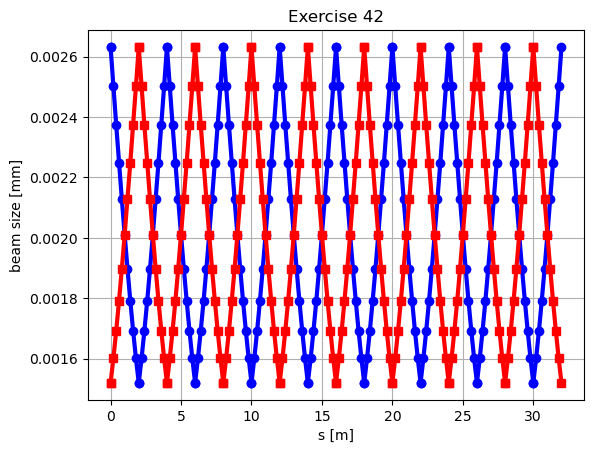

In [9]:
from tracking_library_advanced_solution import transportSigmas4D

f = 2.0
l_cell = 4
l_drift = (l_cell) / 2
fodo_lattice = Q4(f) + 10 * D4(l_drift / 10) + Q4(-f) + 10 * D4(l_drift / 10)
beamline = 8 * fodo_lattice

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss4D(beamline)


epsilon_0 = 1e-6
sigma_0 = epsilon_0 * np.array(
    [
        [betax, -alphax, 0, 0],
        [-alphax, gammax, 0, 0],
        [0, 0, betay, -alphay],
        [0, 0, -alphay, gammay],
    ]
)

transported_sigmas = transportSigmas4D(sigma_0, beamline)
plt.plot(transported_sigmas["s"], np.sqrt(transported_sigmas["sigma11"]), "o-b", lw=3)
plt.plot(transported_sigmas["s"], np.sqrt(transported_sigmas["sigma33"]), "s-r", lw=3)
plt.grid(True)
plt.ylabel("beam size [mm]")
plt.xlabel("s [m]")
plt.title("Exercise 42");

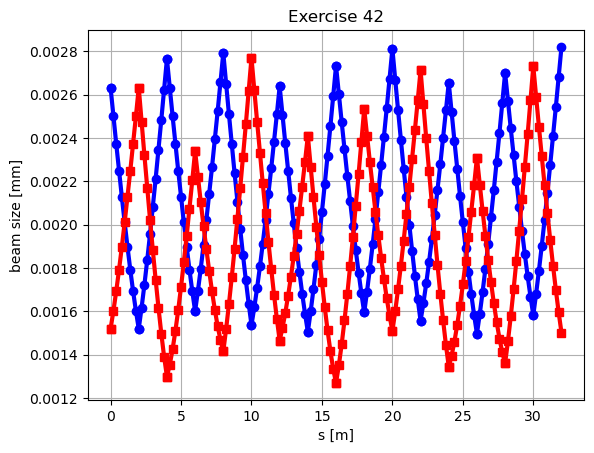

In [10]:
from copy import deepcopy

beamline_new = deepcopy(beamline)
beamline_new[11]["matrix"][1, 0] = beamline_new[11]["matrix"][1, 0] * 1.1
beamline_new[11]["matrix"][3, 2] = beamline_new[11]["matrix"][3, 2] * 1.1

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss4D(fodo_lattice)

epsilon_0 = 1e-6
sigma_0 = epsilon_0 * np.array(
    [
        [betax, -alphax, 0, 0],
        [-alphax, gammax, 0, 0],
        [0, 0, betay, -alphay],
        [0, 0, -alphay, gammay],
    ]
)

transported_sigmas = transportSigmas4D(sigma_0, beamline_new)
plt.plot(transported_sigmas["s"], np.sqrt(transported_sigmas["sigma11"]), "o-b", lw=3)
plt.plot(transported_sigmas["s"], np.sqrt(transported_sigmas["sigma33"]), "s-r", lw=3)
plt.grid(True)
plt.ylabel("beam size [mm]")
plt.xlabel("s [m]")
plt.title("Exercise 42");

## 📝 Exercise 5.5 (guided): Introducing coupling with a solenoid
From the lecture about betatron coupling identify the transfer matrix for a solenoid and write a function that receives the longitudinal magnetic field $B_s$ and the length of the solenoid as input and returns the transfer matrix.  Then extend the simulation code to handle solenoids. Finally, define a beam line where you place the solenoid in the middle of a FODO cell and follow a particle with initial condition $(x_0,x'_0,y_0,y'_0)=(10^{-3}\,\mathrm{m},0,0,0).$ What do you observe? Is the motion confined to the horizontal plane? 

#### SOLUTION
One has to remember that the matrix is
\begin{equation}
M_{\text {SOLENOID}}=\left(\begin{array}{cccc}{C^{2}} & {\frac{1}{K} S C} & {S C} & {\frac{1}{K} S^{2}}\\
{-K S C} & {C^{2}} & {-K S^{2}} & {S C}\\
{-S C} & {-\frac{1}{K} S^{2}} & {C^{2}} & {\frac{1}{K} S C}\\
{K S^{2}} & {-S C} & {-K S C} & {C^{2}}
\end{array}\right)
\end{equation}
where
\begin{equation}
K=\operatorname{sgn}(\mathrm{q}) \frac{B_{s}}{2(B \rho)}
\end{equation}
and
\begin{equation}
\begin{array}{l}{C=\cos K L} \\ {S=\sin K L}\end{array}
\end{equation}

In [11]:
# Import solenoid element
from tracking_library_advanced_solution import solenoid

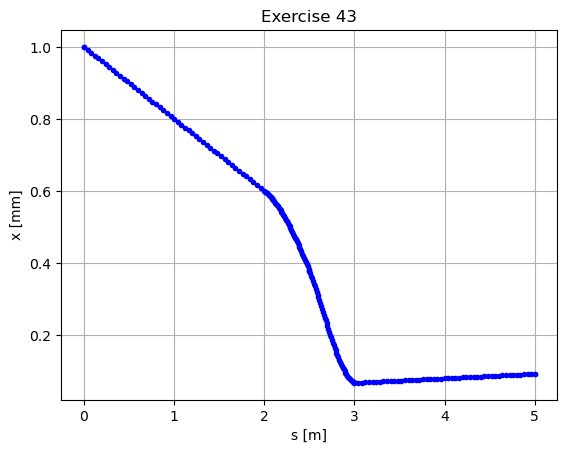

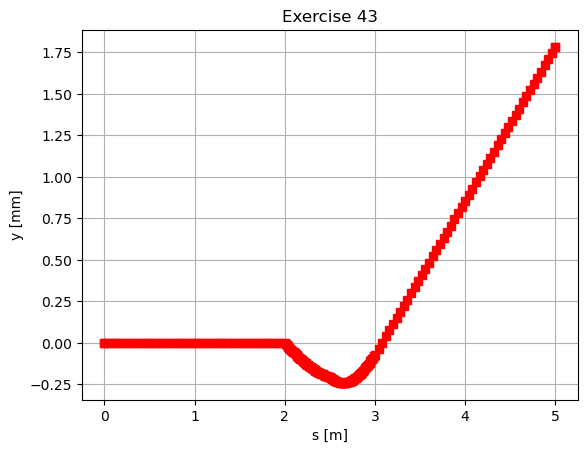

In [12]:
# Import 4D transportParticle function
from tracking_library_advanced_solution import transportParticles4D

f = 2.5
L_2 = 2
fodo_lattice = (
    Q4(2 * f)
    + 50 * D4(L_2 / 50)
    + 50 * solenoid(0.2, 0.01, 0.1, 1)
    + Q4(-f)
    + 50 * solenoid(0.4, 0.01, 0.1, 1)
    + 50 * D4(L_2 / (50))
    + Q4(2 * f)
)

beam = np.array([[1], [0], [0], [0]])

transported_particles = transportParticles4D(beam, fodo_lattice)

plt.plot(transported_particles["s"], transported_particles["x"], ".-b")
plt.xlabel("s [m]")
plt.ylabel("x [mm]")
plt.grid(True)
plt.title("Exercise 43")

plt.figure()
plt.plot(transported_particles["s"], transported_particles["y"], "s-r")
plt.xlabel("s [m]")
plt.ylabel("y [mm]")
plt.grid(True)


One can clearly see that the motion is coupled between the two transverse planes.

---
## Well done! You did all exercises!

=> Now **keep going** and explore other concepts that you have encountered during the lectures!

---